In [1]:
import msacorrnet as mcn
from sklearn.manifold import MDS
import matplotlib.cm as cm
import random
import matplotlib as mpl
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import normalize
import json
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import gaussian_kde

In [2]:
time = int(14400)

file = "data/hts-cp-double-fault-4hr/cpu_usage.json"

f = open(file)

data = json.load(f)
f.close()

f_dict = {}
data = data['data']['result']
for ent in range(len(data)):
    if data[ent]['metric']['id'] != "/":
        f_dict[data[ent]['metric']['pod']] = np.zeros((len(data[ent]['values']), 2))
        f_dict[data[ent]['metric']['pod']][:, 0] = [float(x[0]) for x in data[ent]['values']]
        f_dict[data[ent]['metric']['pod']][:, 1] = [float(x[1]) for x in data[ent]['values']]

for service in f_dict:
    if data[0]["metric"]["__name__"] == "container_memory_usage_bytes":
        pass
    else:
        temp = [0]
        for i in range(1, np.shape(f_dict[service])[0]):
            temp.append(f_dict[service][i, 1] - f_dict[service][i - 1, 1])
        f_dict[service][:, 1] = deepcopy(temp)
        f_dict[service][:, 1] = mcn.sub_sample_zeros(f_dict[service][:, 1])

max_len = 0
for i in f_dict:
    if len(f_dict[i]) > max_len:
        max_len = len(f_dict[i])

aligned_data = mcn.align_data(f_dict, 5, time)
service_list = []
for s in aligned_data:
    service_list.append(s)
s_list = []
for s in aligned_data:
    s_list.append(s)
X = np.zeros((int((time / 5)), len(s_list)))
ind = 0
for s in service_list:
    X[:, ind] = aligned_data[s][:, 1]
    ind += 1
import fnmatch

In [3]:
misc_ms = ["nginx*", "jaeger*"]
for ms in misc_ms:
    matched_indices = [index for index, string in enumerate(service_list) if fnmatch.fnmatchcase(string, ms)]
    if len(matched_indices) > 0:
        s_list.pop(matched_indices[0])
        service_list.pop(matched_indices[0])
        X = np.delete(X, matched_indices[0], axis=1)

In [4]:
dir = os.getcwd()+'/data/hts-cp-double-fault-4hr'
os.chdir(dir)
files = glob.glob('traces_*.json')

spans_list = []
for file in tqdm(files):
    with open(dir + "\\" + file, 'r') as file:
        data = json.load(file)

    spans = data['data']

    for trace in data['data']:
        temp = {'startTime': 0, 'duration': 0}
        for span in trace['spans']:
            if span['duration'] > temp['duration']:
                temp['startTime'] = span['startTime']
                temp['duration'] = span['duration']

        spans_list.append(temp)

df = pd.DataFrame(spans_list)
df['startTime'] = pd.to_datetime(df['startTime'], unit='us')
df['duration'] = df['duration'] / 1e3
df = df.set_index('startTime')
df = df[~df.index.duplicated(keep='first')]
average_response_time_per_second = df['duration'].resample('5s').mean()
calls_per_second = df.resample('5s').size()

100%|██████████| 241/241 [00:11<00:00, 20.60it/s]


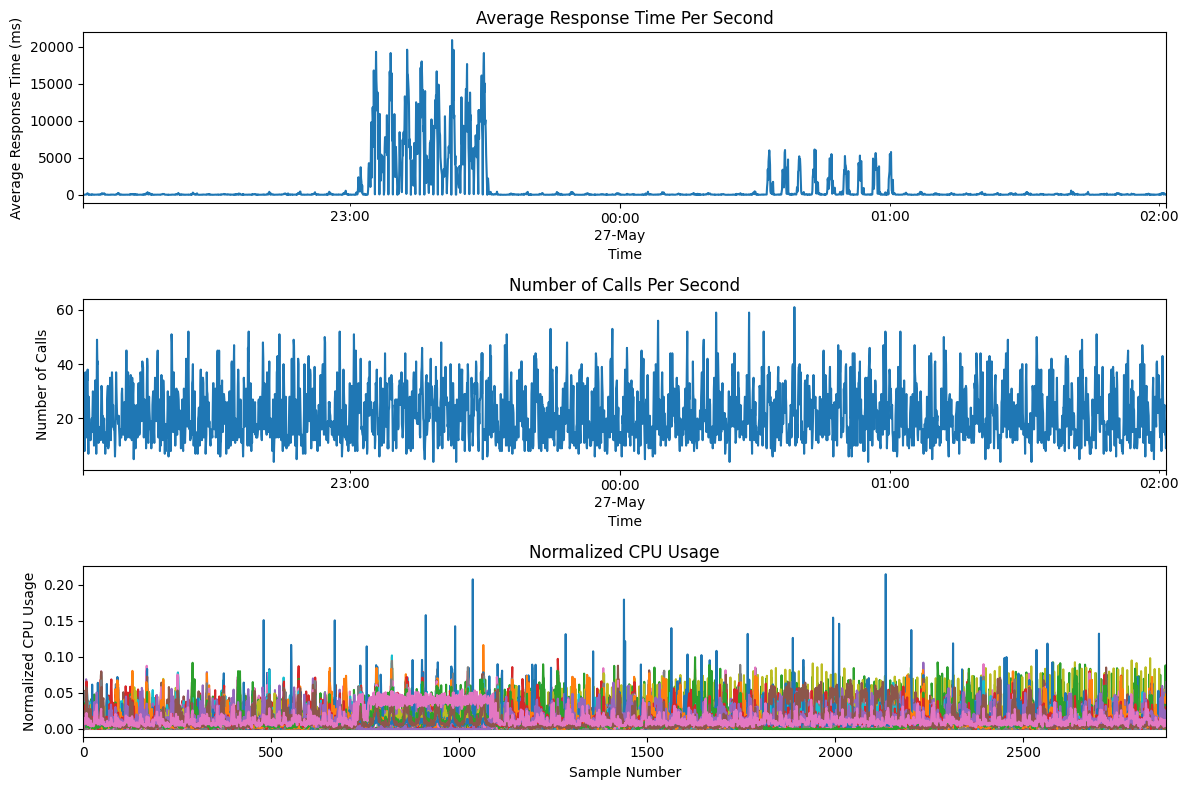

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1) 
average_response_time_per_second.plot()
plt.title('Average Response Time Per Second')
plt.xlabel('Time')
plt.ylabel('Average Response Time (ms)')
plt.subplot(3, 1, 2)
calls_per_second.plot()
plt.title('Number of Calls Per Second')
plt.xlabel('Time')
plt.ylabel('Number of Calls')
plt.subplot(3,1,3)
plt.plot(normalize(X,axis=0))
plt.xlim(0,int(14400/5))
plt.title('Normalized CPU Usage')
plt.xlabel('Sample Number')
plt.ylabel('Normalized CPU Usage')
plt.tight_layout()
plt.show()

In [6]:
win = 360
step = 1
Xc = deepcopy(X)
Xdiff = np.diff(Xc[:, :], axis=0)
Xdiff = normalize(Xdiff, axis=0) 
r_dict = mcn.rolling_window(Xdiff[:, :], win, "tapered", step, 0.3, "tmfg", "pearsons")

D:\Documents\PhD\Code\MSACorrNet-INFOCOM-2025\msacorrnet.py:57: RuntimeWarning: invalid value encountered in true_divide
  R = temp / np.sqrt(np.dot(R, R.T))


In [7]:
r_pos = {}
for corr in r_dict:
    r_pos[corr] = deepcopy(r_dict[corr])
    r_pos[corr] += 1

spectra = mcn.all_spectra(r_pos, True)
all_es = spectra.T
all_es = all_es[:, :-1]
scaling = "LMDS"
if scaling == "LMDS":
    landmarks = random.sample(range(0, all_es.shape[0], 1), int(len(all_es) / 4))
    landmark_es = all_es[landmarks, :]
    dist = distance.cdist(landmark_es, all_es, 'euclidean')
    coords = mcn.LMDS(dist, landmarks, 2)

elif scaling == "MDS":
    dist = distance.cdist(all_es, all_es, 'euclidean')
    mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
    coords = mds.fit_transform(dist)

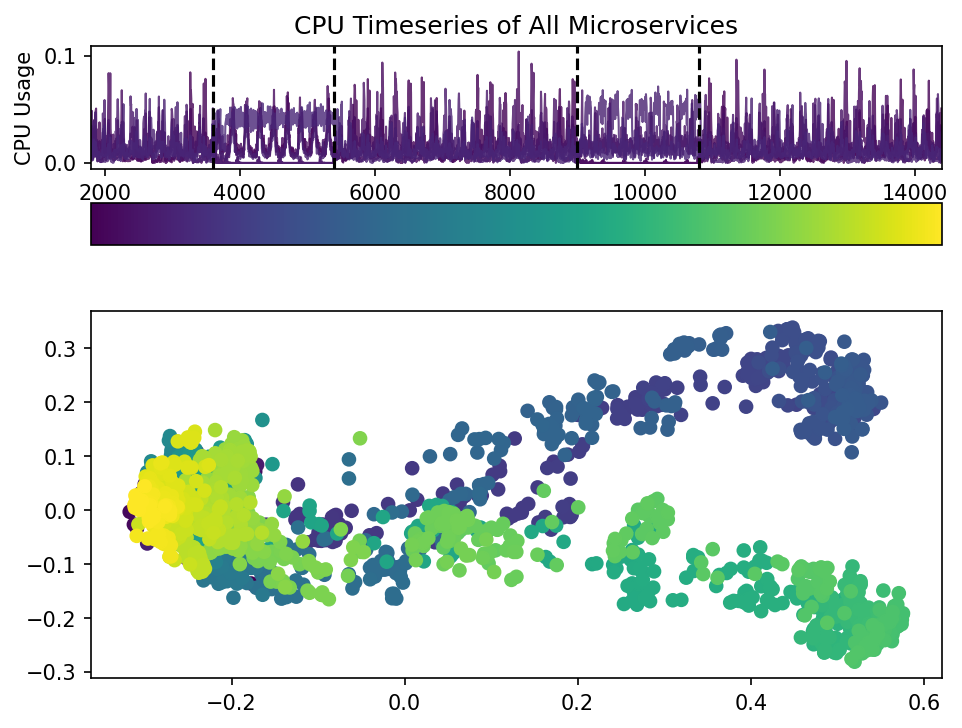

In [8]:
# Finalized plot
fig, ax = plt.subplot_mosaic('AAA;BBB;CCC', gridspec_kw=dict(
    height_ratios=[1, 0.1, 3]), dpi=150)

n = len(r_pos)
t = np.arange(0, n)
cmap_type= 'viridis'
type_color = "tab20c"
cmap = cm.get_cmap(type_color, n)
plt.tight_layout()
fin = int(np.floor(len(X) / step) * step)
ax['A'].set_ylabel('CPU Usage')
ax['A'].set_title('CPU Timeseries of All Microservices')
ax['A'].set_xlabel("Time (s)")
ax['A'].plot(range(win * 5, len(Xc[:, :]) * 5, 5), normalize(Xc[win:, [41, 42, 43, 44, 45, 46]] * 100, axis=0),
             alpha=0.8, linewidth=1)

ax['A'].set_xlim(xmin=win * 5)
ax['A'].set_xlim(xmax=len(X[:, :]) * 5)
cmap = cm.get_cmap(cmap_type, np.shape(X)[1])
colors = [cmap(i) for i in range(np.shape(X)[1])]
for i, j in enumerate(ax['A'].lines):
    j.set_color(colors[i])

ax['A'].axvline((3600), color='k', linestyle='--')
ax['A'].axvline((3600 + 1800), color='k', linestyle='--')
ax['A'].axvline((9000), color='k', linestyle='--')
ax['A'].axvline((9000 + 1800), color='k', linestyle='--')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(int(win * 5), len(X) * 5),
                                          cmap=cmap_type),
                    ax=ax['B'],
                    orientation='horizontal',
                    fraction=3.5,
                    pad=0,
                    )
ax['B'].set_visible(False)

cbar.ax.tick_params(size=0)
cbar.set_ticks([])

ax['C'].scatter(coords[:, 0], coords[:, 1], c=t, cmap=cmap_type, alpha=1)

In [9]:
def remove_after_second_to_last_dash(s):
    dash_positions = [pos for pos, char in enumerate(s) if char == '-']
    
    if len(dash_positions) < 2:
        return s
    else:
        second_to_last_dash_index = dash_positions[-2]
        return s[:second_to_last_dash_index]
    
time = int(7200)

file = "../uts-fault-90m/cpu_usage.json"

f = open(file)

data = json.load(f)
f.close()

f_dict = {}
data = data['data']['result']
for ent in range(len(data)):
    if data[ent]['metric']['id'] != "/":
        f_dict[data[ent]['metric']['pod']] = np.zeros((len(data[ent]['values']), 2))
        f_dict[data[ent]['metric']['pod']][:, 0] = [float(x[0]) for x in data[ent]['values']]
        f_dict[data[ent]['metric']['pod']][:, 1] = [float(x[1]) for x in data[ent]['values']]

for service in f_dict:
    if data[0]["metric"]["__name__"] == "container_memory_usage_bytes":
        pass
    else:
        temp = [0]
        for i in range(1, np.shape(f_dict[service])[0]):
            temp.append(f_dict[service][i, 1] - f_dict[service][i - 1, 1])
        f_dict[service][:, 1] = deepcopy(temp)
        f_dict[service][:, 1] = mcn.sub_sample_zeros(f_dict[service][:, 1])

max_len = 0
for i in f_dict:
    if len(f_dict[i]) > max_len:
        max_len = len(f_dict[i])

aligned_data = mcn.align_data(f_dict, 5, time)
service_list_new = []
for s in aligned_data:
    service_list_new.append(s)
    
s_list_new = []
for s in aligned_data:
    s_list_new.append(s)
X = np.zeros((int((time / 5)), len(s_list_new)))
ind = 0
for s in service_list_new:
    X[:, ind] = aligned_data[s][:, 1]
    ind += 1

import fnmatch
misc_ms = ["nginx*", "jaeger*"]
for ms in misc_ms:
    matched_indices = [index for index, string in enumerate(service_list_new) if fnmatch.fnmatchcase(string, ms)]
    if len(matched_indices) > 0:
        s_list_new.pop(matched_indices[0])
        service_list_new.pop(matched_indices[0])
        X = np.delete(X, matched_indices[0], axis=1)
        
# We need to align ms with original data
s_list = [remove_after_second_to_last_dash(s) for s in s_list]
s_list_new = [remove_after_second_to_last_dash(s) for s in s_list_new]
test = 0
X_aligned = np.zeros(X.shape)

In [10]:
def find_all_positions(lst, target):
    return [index for index, value in enumerate(lst) if value == target]

unique_ms = np.unique(s_list)
for ms in unique_ms:
    new_ind = find_all_positions(s_list, ms)
    old_ind = find_all_positions(s_list_new, ms)
    for i in range(len(new_ind)):
        X_aligned[:, new_ind[i]] = X[:, old_ind[i]]

X = X_aligned

In [11]:
Xc = deepcopy(X)
Xdiff = np.diff(Xc[360:-360, :], axis=0)
Xdiff = normalize(Xdiff, axis=0)
win = 360
step = 1
r_dict_new = mcn.rolling_window(Xdiff[:, :], win, "tapered", step, 0.3, "tmfg", "pearsons")

D:\Documents\PhD\Code\MSACorrNet-INFOCOM-2025\msacorrnet.py:57: RuntimeWarning: invalid value encountered in true_divide
  R = temp / np.sqrt(np.dot(R, R.T))


In [12]:
r_pos_new = {}
for corr in r_dict_new:
    r_pos_new[corr] = deepcopy(r_dict_new[corr])
    r_pos_new[corr] += 1

spectra_new = mcn.all_spectra(r_pos_new, True)
all_es_new = spectra_new.T
all_es_new = all_es_new[:, :-1]
combined_es = np.vstack((all_es, all_es_new))
new_dist = distance.cdist(landmark_es, combined_es, 'euclidean')
combined_coords = mcn.LMDS(new_dist, landmarks, 2)

# Fit a Linear Regression model to find the affine transformation
regressor = LinearRegression()
regressor.fit(combined_coords[:-359,:], coords)

# Apply the transformation to the new points
new_coords = regressor.predict(combined_coords[-359:,:])
new_coords = np.vstack((coords,new_coords))

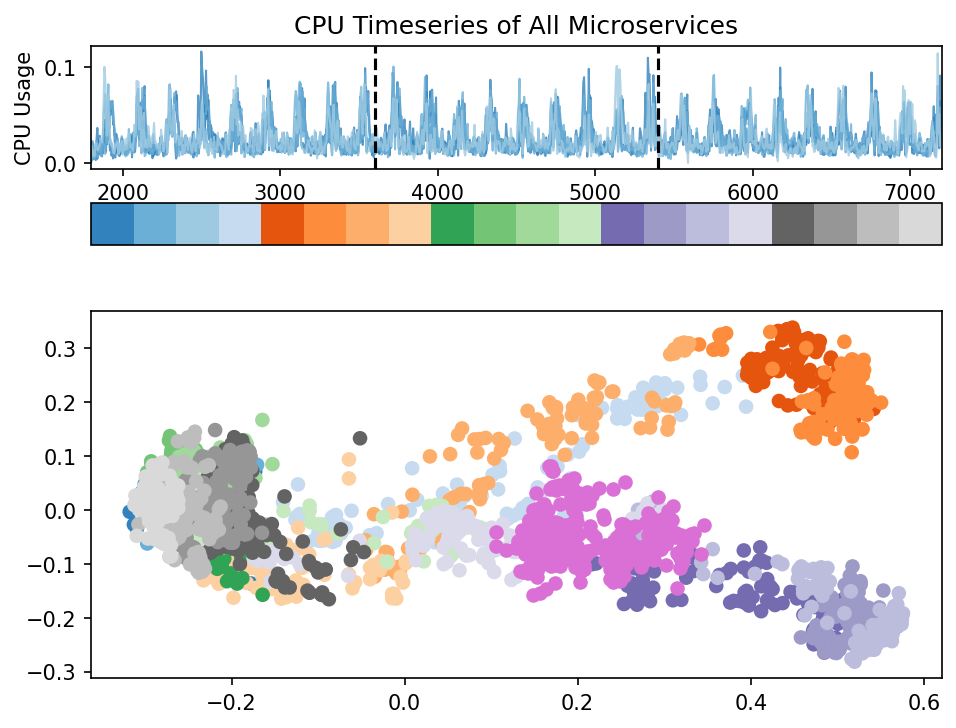

In [13]:
cmap_type = "tab20c"
# Finalized plot
fig, ax = plt.subplot_mosaic('AAA;BBB;CCC', gridspec_kw=dict(
    height_ratios=[1, 0.1, 3]), dpi=150)

n = len(r_pos) + len(r_pos_new)
type_color = "tab20c"
cmap = cm.get_cmap(type_color, n)
t = np.arange(0, n)
plt.tight_layout()
fin = int(np.floor(len(X) / step) * step)
ax['A'].set_ylabel('CPU Usage')
ax['A'].set_title('CPU Timeseries of All Microservices')
ax['A'].set_xlabel("Time (s)")
ax['A'].plot(range(win * 5, len(Xc[:, :]) * 5, 5), normalize(Xc[win:, [41, 42, 43, 44, 45, 46]] * 100, axis=0),
             alpha=0.8, linewidth=1)

# ax['A'].set_ylim(ymax=300)
ax['A'].set_xlim(xmin=win * 5)
ax['A'].set_xlim(xmax=len(X[:, :]) * 5)
cmap = cm.get_cmap(cmap_type, np.shape(X)[1])
colors = [cmap(i) for i in range(np.shape(X)[1])]
for i, j in enumerate(ax['A'].lines):
    j.set_color(colors[i])

ax['A'].axvline((3600), color='k', linestyle='--')
ax['A'].axvline((3600 + 1800), color='k', linestyle='--')
ax['A'].axvline((9000), color='k', linestyle='--')
ax['A'].axvline((9000 + 1800), color='k', linestyle='--')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(int(win * 5), time),
                                          cmap=cmap_type),
                    ax=ax['B'],
                    orientation='horizontal',
                    fraction=3.5,
                    pad=0,
                    )
ax['B'].set_visible(False)

cbar.ax.tick_params(size=0)
cbar.set_ticks([])

# Create a new 3D subplot
# ax_3d.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=t, cmap=cmap_type, alpha=1)

ax['C'].scatter(new_coords[:-361, 0], new_coords[:-361, 1], c=t[:-361], cmap=cmap_type, alpha=1)
ax['C'].scatter(new_coords[-359:, 0], new_coords[-359:, 1], c='orchid', alpha=1)

In [14]:
clustering = AgglomerativeClustering(3, linkage="average").fit(coords)
original_embeddings = coords
original_labels = clustering.labels_
clustering = AgglomerativeClustering(3, linkage="average").fit(new_coords)
new_embeddings = new_coords[-360:, :]
new_labels = clustering.labels_[-360:]

In [15]:
def normalize_kde(cluster_data):
    kde = gaussian_kde(cluster_data)
    values = kde.evaluate(cluster_data)
    max_value = np.max(values)
    normalized_kde = lambda x: kde(x) / max_value
    return normalized_kde

def compute_centroids(embeddings, labels):
    unique_labels = np.unique(labels)
    centroids = {label: embeddings[labels == label].mean(axis=0) for label in unique_labels}
    return centroids

def calculate_distances(embeddings, centroids, labels):
    distances = {label: [] for label in centroids}
    for i, label in enumerate(labels):
        centroid = centroids[label]
        distance = np.linalg.norm(embeddings[i] - centroid)
        distances[label].append(distance)
    return distances

def compute_z_scores(distances):
    z_scores = {}
    for label, dist in distances.items():
        mean_dist = np.mean(dist)
        std_dist = np.std(dist)
        z_scores[label] = (np.array(dist) - mean_dist) / std_dist
    return z_scores

centroids = compute_centroids(original_embeddings, original_labels)
distances = calculate_distances(original_embeddings, centroids, original_labels)
z_scores = compute_z_scores(distances)

kdes = {label: normalize_kde(z_scores[label]) for label in z_scores}

original_probabilities = []
original_clusters = []
for i, embedding in enumerate(original_embeddings):
    label = original_labels[i]
    centroid = centroids[label]
    distance = np.linalg.norm(embedding - centroid)
    mean_dist = np.mean(distances[label])
    std_dist = np.std(distances[label])
    z_score = (distance - mean_dist) / std_dist
    probability_density = kdes[label](z_score)
    original_probabilities.append(probability_density[0])
    original_clusters.append(label)

# Compute z-scores and probabilities for new embeddings
new_probabilities = []
new_z_scores = []
new_clusters = []
for i, new_embedding in enumerate(new_embeddings):
    predicted_label = new_labels[i]
    centroid = centroids[predicted_label]
    distance = np.linalg.norm(new_embedding - centroid)
    mean_dist = np.mean(distances[predicted_label])
    std_dist = np.std(distances[predicted_label])
    z_score = (distance - mean_dist) / std_dist
    new_z_scores.append(z_score)
    probability_density = kdes[predicted_label](z_score)
    new_probabilities.append(probability_density[0])
    new_clusters.append(predicted_label)

# Combine probabilities and clusters
all_probabilities = original_probabilities + new_probabilities
all_clusters = original_clusters + new_clusters

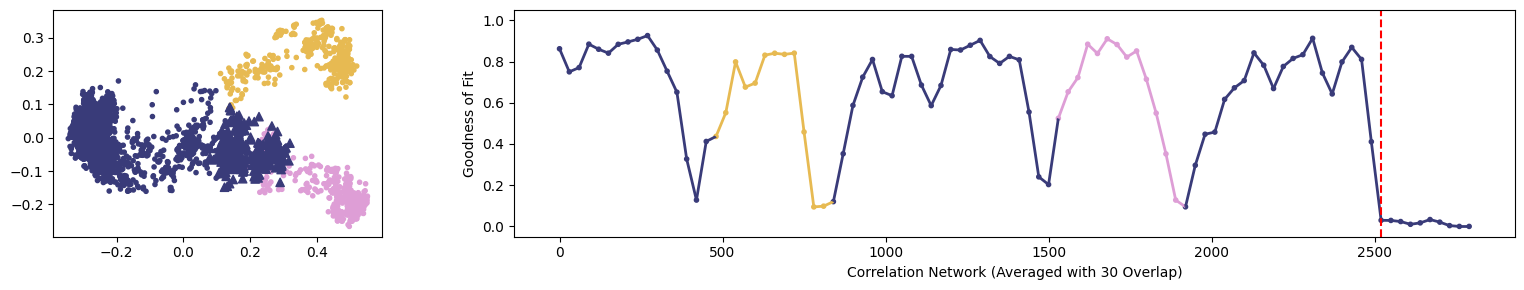

In [16]:
def moving_average(data, window_size, overlap):
    result = []
    step = window_size - overlap
    for i in range(0, len(data) - window_size + 1, step):
        window_avg = np.mean(data[i:i + window_size])
        result.append(window_avg)
    return result

window_size = 60
overlap = 30
all_probabilities_np = np.array(all_probabilities)
averaged_probabilities = moving_average(all_probabilities_np, window_size, overlap)
averaged_probabilities_np = np.array(averaged_probabilities)

cmap = cm.get_cmap("tab20b", 3)
unique_clusters = np.unique(all_clusters)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))
color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}
cluster_colors = np.array([color_map[cluster] for cluster in all_clusters])
cluster_colors = cluster_colors[:-1]
averaged_cluster_colors = [cluster_colors[i] for i in range(0, len(all_probabilities_np) - window_size + 1, window_size - overlap)]

fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

ax1 = plt.subplot(gs[0])
scatter = ax1.scatter(combined_coords[:-360, 0], combined_coords[:-360, 1], c=cluster_colors[:-360], marker='.')
scatter = ax1.scatter(combined_coords[-360:, 0], combined_coords[-360:, 1], c=cluster_colors[-360:], marker='^')
ax1.set_aspect('equal', 'box')

ax2 = plt.subplot(gs[1])
x_vals = range(0, len(averaged_probabilities_np) * (window_size - overlap), (window_size - overlap))
segments = [[(x_vals[i], averaged_probabilities_np[i]), (x_vals[i + 1], averaged_probabilities_np[i + 1])] for i in range(len(averaged_probabilities_np) - 1)]
lc = LineCollection(segments, colors=averaged_cluster_colors, linewidth=2)
ax2.add_collection(lc)
ax2.autoscale()
ax2.scatter(range(0, len(averaged_probabilities_np)*30, 30), averaged_probabilities_np, c=averaged_cluster_colors, marker='.')
ax2.axvline(x=(len(all_probabilities) - 360), color='r', linestyle='--', label='New Data Points Start')
ax2.set_xlabel('Correlation Network (Averaged with 30 Overlap)')
ax2.set_ylabel('Goodness of Fit')
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [17]:
clustering = AgglomerativeClustering(4, linkage="average").fit(new_coords)
update_labels = clustering.labels_

original_embeddings = combined_coords
original_labels = update_labels

centroids = compute_centroids(original_embeddings, original_labels)
distances = calculate_distances(original_embeddings, centroids, original_labels)
z_scores = compute_z_scores(distances)

kdes = {label: normalize_kde(z_scores[label]) for label in z_scores}

original_probabilities = []
original_clusters = []
for i, embedding in enumerate(original_embeddings):
    label = original_labels[i]
    centroid = centroids[label]
    distance = np.linalg.norm(embedding - centroid)
    mean_dist = np.mean(distances[label])
    std_dist = np.std(distances[label])
    z_score = (distance - mean_dist) / std_dist
    probability_density = kdes[label](z_score)
    original_probabilities.append(probability_density[0])
    original_clusters.append(label)
    
new_probabilities = []
new_z_scores = []
new_clusters = []
for i, new_embedding in enumerate(new_embeddings):
    predicted_label = new_labels[i]
    centroid = centroids[predicted_label]
    distance = np.linalg.norm(new_embedding - centroid)
    mean_dist = np.mean(distances[predicted_label])
    std_dist = np.std(distances[predicted_label])
    z_score = (distance - mean_dist) / std_dist
    new_z_scores.append(z_score)
    probability_density = kdes[predicted_label](z_score)
    new_probabilities.append(probability_density[0])
    new_clusters.append(predicted_label)

all_probabilities = original_probabilities
all_clusters_new = original_clusters

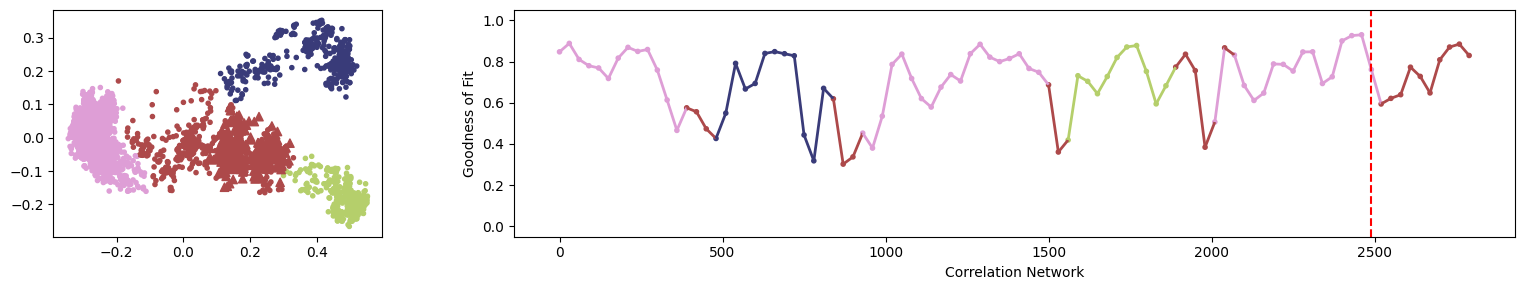

In [18]:
# Create a colormap with specific colors for the first three clusters and a new color for the fourth cluster
cmap = cm.get_cmap("tab20b", 4)
colors = list(cmap(np.linspace(0, 1, 4)))

# Original cluster color mapping
color_map = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3]}
cluster_colors = np.array([color_map[cluster] for cluster in update_labels])
averaged_cluster_colors = [cluster_colors[i] for i in range(0, len(all_probabilities_np) - window_size + 1, window_size - overlap)]

window_size = 60
overlap = 30

all_probabilities_np = np.array(all_probabilities)
averaged_probabilities = moving_average(all_probabilities_np, window_size, overlap)
averaged_probabilities_np = np.array(averaged_probabilities)
range(0, len(all_probabilities_np) - window_size + 1, window_size - overlap)

fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

ax1 = plt.subplot(gs[0])
averaged_cluster_colors = [cluster_colors[i] for i in range(0, len(all_probabilities_np) - window_size + 1, window_size - overlap)]
scatter = ax1.scatter(combined_coords[:-360, 0], combined_coords[:-360, 1], c=cluster_colors[:-360], marker='.')
scatter = ax1.scatter(combined_coords[-360:, 0], combined_coords[-360:, 1], c=cluster_colors[-360:], marker='^')
ax1.set_aspect('equal', 'box')


ax2 = plt.subplot(gs[1])
x_vals = range(0, len(averaged_probabilities_np) * (window_size - overlap), (window_size - overlap))
segments = [[(x_vals[i], averaged_probabilities_np[i]), (x_vals[i + 1], averaged_probabilities_np[i + 1])] for i in range(len(averaged_probabilities_np) - 1)]
lc = LineCollection(segments, colors=averaged_cluster_colors, linewidth=2)
ax2.add_collection(lc)
ax2.autoscale()
ax2.scatter(x_vals, averaged_probabilities_np, c=averaged_cluster_colors, marker='.')

new_data_start = (len(all_probabilities) - 360) // (window_size - overlap)
ax2.axvline(x=new_data_start * (window_size - overlap), color='r', linestyle='--', label='New Data Points Start')
ax2.set_xlabel('Correlation Network')
ax2.set_ylabel('Goodness of Fit')
ax2.set_ylim(-0.05,1.05)

plt.tight_layout()
plt.show()